In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:13 https://developer.download.n

In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2021-11-23 03:16:20--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.51MB/s    in 0.6s    

2021-11-23 03:16:22 (1.51 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [4]:
from pyspark import SparkFiles
# Load in csv from S3 into a DataFrame
url = "https://yelpproject4.s3.amazonaws.com/yelp_restaurants.csv"
spark.sparkContext.addFile(url)

df = spark.read.option('header', 'true').csv(SparkFiles.get("yelp_restaurants.csv"), inferSchema=True, sep=',', timestampFormat="mm/dd/yy")
df.show(10)

+--------------------+--------------------+--------------------+-----------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|       city|state|postal_code|     latitude|      longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+--------------------+--------------------+-----------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|        921 Pearl St|    Boulder|   CO|      80302|   40.0175444|   -105.2833481|  4.0|          86|      1|"{'RestaurantsTab...| 'BikeParking': '...| 'BusinessParking...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...| 7000 NE Airport Way|   Portland|   OR|      97218|45.5889058992|-122.5933307507|  4.0|         1

In [55]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [61]:
yelp = df.toPandas()

In [63]:
yelp['stars']= yelp['stars'].astype(float)

In [64]:
def ycolumn(x):
  stars = x['stars']
  if stars >= 3:
    return 1
  else:
    return 0
yelp['Stars Y'] = yelp.apply(lambda x: ycolumn(x),axis=1)

In [79]:
x=pd.get_dummies(yelp['categories'])

In [6]:
df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- is_open: integer (nullable = true)
 |-- attributes: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- hours: string (nullable = true)



In [80]:
# X = yelp.drop('is_open', axis=1)
y = yelp['Stars Y']
X=x
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
clf = RandomForestClassifier(random_state=1, n_estimators=100).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 0.8473934043970687
Testing Score: 0.8404946290282288


In [83]:
feature_importances = clf.feature_importances_

[2.34978366e-03 1.49993451e-03 9.85293451e-04 ... 1.12746672e-05
 1.19940142e-05 0.00000000e+00]


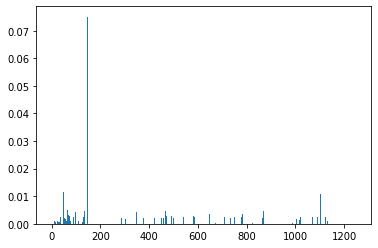

In [86]:
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=1, n_estimators=500, base_estimator=DecisionTreeClassifier(max_depth=2)).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.72
